# Исследование алгоритмов кластеризации

In [24]:
pip freeze > "requirements (2).txt"

Note: you may need to restart the kernel to use updated packages.


# Импорт библиотек

In [1]:
import re
import string

import seaborn as sns
import spacy
import wget
from loguru import logger
import tqdm
import nltk
import numpy as np
import gensim,  logging
import pandas as pd
from razdel import tokenize
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText
from natasha import MorphVocab
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 

# Функции предобработки текста

### Токенизация, лемматизация, приведение к нижнему регистру

In [2]:
def preprocess_text(
                    text, 
                    nlp,
                    punctuation, 
                    stop_words
                    ):
    doc = nlp(text.lower())  # Привести к нижнему регистру и лемматизировать
    lemmatized_words = [token.lemma_ for token in doc if token.text not in punctuation and token.text not in stop_words 
                        and token.pos_ not in ["PUNCT", "SYM", "SPACE"] and len(token.text) > 2]
    return " ".join(lemmatized_words)

### Удаление стоп-слов, пунктуации, возвращает массив обработанных документов

In [3]:
def tokenize(
            documents: str
            ):
    nlp = spacy.load("ru_core_news_sm")
    nltk.download('stopwords')
    nltk.download('punkt')
    stop_words = set(stopwords.words('russian'))
    punctuation = set(string.punctuation)
    processed_text = []
    for text in documents:
        preprocessed_text = preprocess_text(text, nlp, punctuation, stop_words)
        # print("Оригинальный текст:", text)
        # print("Предобработанный текст:", preprocessed_text)
        # print("<----------------------------------------------->")
        processed_text.append(preprocessed_text)
    return processed_text 

# Методы векторизации текста

## Простые векторные представления

### TF-IDF векторизация документов

In [4]:
def tfidf_vectorizer(processed_text):
    tfidf = TfidfVectorizer(smooth_idf = True, norm = 'l2',  ngram_range = (2,2))  
    tfidf_matrix = tfidf.fit_transform(processed_text)
    important_words = tfidf.get_feature_names_out()
    # print("Метод векторизации TF-IDF:")
    # print("Важные слова:", important_words)
    return tfidf_matrix

### Векторизация методом BagOfWords

In [5]:
def count_vectorizer(processed_text):
    count_vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2,2))
    token_counter = count_vectorizer.fit_transform(processed_text)
    cv_features = count_vectorizer.get_feature_names_out()
    print("Метод векторизации BoW:")
    cv_dataframe = pd.DataFrame(token_counter.toarray(), columns = cv_features)
    return cv_dataframe

## Сложные векторные представления

### Word2Vec

#### Векторизация

In [6]:
def W2V_vectorizer(
                    dataframe, 
                    model
                    ):
    model_name = model
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    tokens_col = dataframe['tokens'].tolist()
    model = gensim.models.KeyedVectors.load_word2vec_format(model_name, binary = True)
    features = []
    for tokens in tokens_col:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    dataframe['vectors'] = features
    print("Метод векторизации Word2Vec")
    print("Количество векторов: ", len(features))
    print("Длина вектора: ", len(features))
    print
    return features

#### Обучениее модели

In [7]:
def W2V_training(dataframe):
    logger.debug("Токенизация....")
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    logger.success("Токенизация завершена успешно!")
    tokens_col = dataframe['tokens'].tolist()
    #1 - skipgram, 0 -cbow
    for algorithm in range(0,1):
        if algorithm == 0:
            logger.debug("Обучение методом CBOW")
            model = gensim.models.Word2Vec(window=40, min_count=2, workers=3, vector_size=300, sg=algorithm)
            model.build_vocab(dataframe['tokens'])
            logger.debug(f"Количество строк в корпусе: {model.corpus_count}")
            logger.debug("Обучение...")
            model.train(dataframe['tokens'],  epochs=model.epochs, total_examples=model.corpus_count)
            logger.success("Обучение завершено!")
            model_filename = f"w2v_cbow_{model.corpus_count}.bin"
            model.wv.save_word2vec_format(model_filename, binary=True)
            logger.success(f"Модель сохранена в {model_filename}")
            
        logger.debug("Обучение методом SkipGram")
        model = gensim.models.Word2Vec(window=40, min_count=2, workers=3, vector_size=300, sg=algorithm)
        model.build_vocab(dataframe['tokens'])
        logger.debug(f"Количество строк в корпусе: {model.corpus_count}")
        logger.debug("Обучение...")
        model.train(dataframe['tokens'],  epochs=model.epochs, total_examples=model.corpus_count)
        logger.success("Обучение завершено!")
        model_filename = f"w2v_skipgram_{model.corpus_count}.bin"
        model.wv.save_word2vec_format(model_filename, binary=True)
        logger.success(f"Модель сохранена в {model_filename}")

### FastText

In [8]:
def FastText_training(dataframe):
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    tokens_col = dataframe['tokens'].tolist()
    
    #    Параметры модели
    embedding_size = 100
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    
    ft_model = FastText(tokens_col,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=20)
    
    semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['я_NOUN', 'приехать_VERB', 'москва_PROPN', 'фотографировать_VERB', 'красиво_ADJ']}

    for k,v in semantically_similar_words.items():
        print(k+":"+str(v))

### Glove

# Методы кластеризации текста

## Вычисление оптимального количества кластеров. Метод локтя

In [9]:
def elbow_method(scaled_df):
    kmeans_kwargs = {
                    "init": "random",
                    "n_init": 10,
                    "random_state": 1,
                    }
    
    #create list to hold SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
        kmeans.fit(scaled_df)
        sse.append(kmeans.inertia_)
    
    #visualize results
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Число кластеров")
    plt.ylabel("SSE")
    plt.show()

## K-Means

In [10]:
def kmeans_clusterization(
                            vectorized_text, 
                            n_clusters
                            ):
    #Инициализация метода главных компонент
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    clusters = kmeans.fit_predict(vectorized_text)
    print(f"For number of {n_clusters}:")
    print(f"Silhouette Coefficient: {metrics.silhouette_score(vectorized_text, clusters):.3f}")
    print(f"Inertia:{kmeans.inertia_}")


## MBK-Means

In [11]:
def mbkmeans_clusterization(
        X, 
        k, 
        mb, 
        print_silhouette_values, 
    ):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters = k, batch_size = mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key =lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

## DBScan

In [12]:
def dbscan_clusterization(
                            X, 
                            eps, 
                            min_samples
                            ):
    db = DBSCAN(eps = eps, min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

# Чтение датасета

In [21]:
news_df = pd.read_csv('reduced_news.csv', delimiter =',', low_memory = True)

In [22]:
news_df

,Unnamed: 0,url,title,text,topic,tags,date
0,0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
3,4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
4,5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15
...,...,...,...,...,...,...,...
423822,496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
423823,496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
423824,496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
423825,496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [23]:
logger.success(f'Теги новостей: {news_df["tags"].unique()}, Количество: {len(news_df["tags"].unique())}')
logger.error(f'Темы новостей: {news_df["topic"].unique()}, Количество: {len(news_df["topic"].unique())}')

2024-03-14 20:26:48.182 | SUCCESS  | __main__:<module>:1 - Теги новостей: ['Общество' 'Политика' 'Культура' 'Интернет' 'Из жизни' 'Наука и техника'
 'Мир' 'Россия' 'Полиция и спецслужбы' 'Футбол' 'Белоруссия' 'Бокс и ММА'
 'ТВ и радио' 'Экономика' 'СВО/Украина' 'Следствие и суд' 'Среда обитания'
 'Явления' 'Забота о себе'], Количество: 19
2024-03-14 20:26:48.240 | ERROR    | __main__:<module>:2 - Темы новостей: ['Россия' 'Культура' 'Мир' 'Интернет и СМИ' 'Наука и техника'
 'Путешествия' 'Силовые структуры' 'Спорт' 'Из жизни' 'Бывший СССР'
 'Экономика' 'Нацпроекты' 'Среда обитания' 'Дом' 'Ценности'
 '69-я параллель' 'Бизнес' 'Моя страна' 'Забота о себе'], Количество: 19


In [15]:
actual_news_df = pd.read_csv('reduced_news.csv', delimiter =',')

In [16]:
actual_news_df

,Unnamed: 0,url,title,text,topic,tags,date
0,0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
3,4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
4,5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15
...,...,...,...,...,...,...,...
423822,496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
423823,496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
423824,496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
423825,496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [ ]:
actual_news_df = actual_news_df.dropna()

In [14]:
actual_news_df["tags"] = actual_news_df["tags"].replace("Украина", "СВО/Украина")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Фотография', 'Музыка', 'Кино', 'Искусство', 'Театр', 'Книги', 'Сериалы'], "Культура")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Социальная сфера', 'Госэкономика', 'Деловой климат',
       'Бизнес', 'Рынки', 'Капитал', 'Инвестиции'], "Экономика")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Звери', 'Происшествия', 'Люди', 'Еда', 'Персоны',
       'Счастливчики', 'Аномалии'], "Из жизни")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Наука', 'Гаджеты', 'Оружие', 'Космос', 'История', 'Здоровье',
       'Техника', 'Игры', 'Софт', 'Будущее', 'В России'], "Наука и техника")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Город', 'Дом', 'Климат и экология', 'Край', 'Транспорт'], "Среда обитания")
actual_news_df["tags"] = actual_news_df["tags"].replace(['Уход за собой', 'Питание и сон', 'Ментальное здоровье',
       'Окружающее пространство', 'Отношения'], "Забота о себе")
actual_news_df

C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\1687738998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df["tags"] = actual_news_df["tags"].replace("Украина", "СВО/Украина")
C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\1687738998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df["tags"] = actual_news_df["tags"].replace(['Фотография', 'Музыка', 'Кино', 'Искусство', 'Театр', 'Книги', 'Сериалы'], "Культура")
C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\1687738

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
...,...,...,...,...,...,...
496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [24]:
actual_news_df[actual_news_df["topic"] == "Культура"]["tags"].unique()


array(['Фотография', 'Музыка', 'Кино', 'Искусство', 'Театр', 'Книги',
       'Все', 'Сериалы'], dtype=object)

In [25]:
actual_news_df[actual_news_df["topic"] == "Экономика"]["tags"].unique()

array(['Социальная сфера', 'Госэкономика', 'Все', 'Деловой климат',
       'Бизнес', 'Рынки', 'Капитал', 'Инвестиции'], dtype=object)

In [26]:
actual_news_df[actual_news_df["topic"] == "Из жизни"]["tags"].unique()

array(['Звери', 'Происшествия', 'Люди', 'Еда', 'Все', 'Персоны',
       'Счастливчики', 'Аномалии'], dtype=object)

In [28]:
actual_news_df[actual_news_df["topic"] == "Наука и техника"]["tags"].unique()

array(['Наука', 'Гаджеты', 'Оружие', 'Космос', 'История', 'Здоровье',
       'Техника', 'Игры', 'Все', 'Софт', 'Будущее', 'В России'],
      dtype=object)

In [30]:
actual_news_df[actual_news_df["topic"] == "Среда обитания"]["tags"].unique()

array(['Город', 'Дом', 'Все', 'Климат и экология', 'Край', 'Транспорт'],
      dtype=object)

In [33]:
actual_news_df[actual_news_df["topic"] == "Забота о себе"]["tags"].unique()

array(['Уход за собой', 'Питание и сон', 'Ментальное здоровье',
       'Окружающее пространство', 'Отношения', 'Все'], dtype=object)

In [20]:
category_counts = actual_news_df['tags'].value_counts()

min_count = 15000
# Отфильтровываем строки, где количество категорий больше или равно min_count
actual_news_df = actual_news_df[actual_news_df['tags'].isin(category_counts[category_counts > min_count].index)]



,Unnamed: 0,url,title,text,topic,tags,date
0,0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15
3,4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
4,5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15
...,...,...,...,...,...,...,...
423822,496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
423823,496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
423824,496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
423825,496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [31]:
actual_news_df[actual_news_df["tags"] == "Следствие и суд"]

,Unnamed: 0,url,title,text,topic,tags,date
52,60,https://lenta.ru/news/2019/12/15/pod/,Заплатившие за выход на подиум десятки тысяч р...,Сотрудничавшие с московским модельным агентств...,Силовые структуры,Следствие и суд,2019-12-15
63,73,https://lenta.ru/news/2019/12/15/ferg/,В деле похитивших миллиарды братьев Магомедовы...,В деле обвиняемых в миллиардных хищениях совла...,Силовые структуры,Следствие и суд,2019-12-15
113,135,https://lenta.ru/news/2019/12/16/wild/,Экс-министра финансов Подмосковья приговорили ...,Басманный суд Москвы вынес приговор бывшему ми...,Силовые структуры,Следствие и суд,2019-12-16
130,156,https://lenta.ru/news/2019/12/16/zozulya/,Гособвинение запросило новую экспертизу по дел...,Гособвинение направило в суд ходатайство о про...,Силовые структуры,Следствие и суд,2019-12-16
139,166,https://lenta.ru/news/2019/12/16/bellahadid/,Историк-расчленитель несколько раз пытался пок...,"Александр Почуев, адвокат историка Олега Сокол...",Силовые структуры,Следствие и суд,2019-12-16
...,...,...,...,...,...,...,...
423535,495928,https://lenta.ru/news/2023/12/30/cancer/,Подозреваемому в убийстве отца Легойды предъяв...,Следователь ГСУ Следственного комитета России ...,Силовые структуры,Следствие и суд,2023-12-30
423599,495997,https://lenta.ru/news/2023/12/30/kiev-poobesch...,Блиновской отказали в снятии ареста с ее счетов,Арбитражный суд Москвы отклонил ходатайство бл...,Силовые структуры,Следствие и суд,2023-12-30
423627,496027,https://lenta.ru/news/2023/12/30/igroki-detsko...,Подозреваемый в убийстве отца Легойды призналс...,Подозреваемый в убийстве отца главы пресс-служ...,Силовые структуры,Следствие и суд,2023-12-30
423629,496030,https://lenta.ru/news/2023/12/30/v-rossii-poob...,Следователи раскрыли подробности убийства Легойды,Подозреваемый в убийстве Романа Легойды напал ...,Силовые структуры,Следствие и суд,2023-12-30


In [23]:

actual_news_df.drop(actual_news_df.loc[actual_news_df["tags"] == "Среда обитания"].index, inplace=True)


In [39]:
actual_news_df.to_csv('reduced_news_with_vetors.csv', encoding='utf-8')

In [13]:
vectorized_news_df = pd.read_csv('reduced_news_with_vetors.csv', delimiter =',')
vectorized_news_df

,Unnamed: 0.1,Unnamed: 0,url,title,text,topic,tags,date,tokens,vectors
0,0,0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15,"['россиянин_NOUN', 'дать_VERB', 'совет_NOUN', ...",[ 1.92573354e-01 1.75421938e-01 6.22912347e-...
1,1,1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15,"['спикер_NOUN', 'госдума_PROPN', 'вячеслав_PRO...",[-0.17792627 -0.34801978 -0.6558388 -0.263101...
2,2,2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15,"['украинская_ADJ', 'лгбт_PROPN', 'активистка_N...",[-1.98362097e-01 4.53301184e-02 -7.10412934e-...
3,3,4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15,"['исполнять_VERB', 'обязанность_NOUN', 'презид...",[-0.44590008 -0.7543499 -0.7748393 0.022261...
4,4,5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15,"['загс_NOUN', 'казань_PROPN', 'официально_ADV'...",[-0.06883645 0.54412717 0.06642661 -0.497118...
...,...,...,...,...,...,...,...,...,...,...
334267,423822,496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01,"['глава_NOUN', 'донецкий_ADJ', 'народный_ADJ',...",[ 1.2723573 -0.7883604 1.3933644 0.618501...
334268,423823,496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01,"['январь_NOUN', '2024_ADJ', 'год_NOUN', 'начат...",[-0.23262587 -0.0988141 -0.5287248 -0.990285...
334269,423824,496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01,"['январь_NOUN', '2024_ADJ', 'год_NOUN', 'матер...",[-0.5412548 0.40643695 -0.3793554 -1.362960...
334270,423825,496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01,"['директор_NOUN', 'украинского_ADJ', 'институт...",[-0.03866944 -1.5884598 -0.5304405 -0.853067...


In [57]:
def preprocessingTextNatasha():
    morph_vocab = MorphVocab()
    texts = ["На Украине высказались о возможной смене власти", "Бразилия присоединилась к ОПЕК+"]
    tokens = [list(tokenize(text)) for text in texts]
    tokenized_texts = [[_.text for _ in token] for token in tokens]
    for tokenized_text in tokenized_texts
        for token in tokenized_text.tokens:
            token.lemmatize(morph_vocab)
    lowered_texts = [list(map(lambda x: x.lower(), tokenized_text)) for tokenized_text in tokenized_texts]
    pattern = re.compile(r'[\W\d]+')
    cleaned_array = [[pattern.sub('', word) for word in sublist] for sublist in lowered_texts]
    cleaned_array = [[word for word in sublist if word] for sublist in cleaned_array]
    print(cleaned_array)
    
preprocessingTextNatasha()

[['на', 'украине', 'высказались', 'о', 'возможной', 'смене', 'власти'], ['бразилия', 'присоединилась', 'к', 'опек']]


In [21]:
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
navec['конец
']

array([ 1.28306076e-01,  2.90970147e-01, -2.92980611e-01,  1.25398725e-01,
        4.43409771e-01, -4.60764468e-01,  1.72386423e-01,  3.08265597e-01,
       -1.75276101e-01, -1.18417926e-01, -3.44018430e-01, -1.00254148e-01,
       -9.53090340e-02, -4.24427211e-01, -4.10307981e-02,  5.34212589e-01,
       -8.75450373e-02,  3.16088647e-01,  2.49961331e-01,  5.01047611e-01,
       -2.45158270e-01, -3.09264839e-01, -3.45256746e-01,  2.39722654e-01,
        2.97107965e-01,  6.23290300e-01,  2.08043709e-01, -5.91362603e-02,
        1.85202589e-04, -4.47340995e-01,  1.38779014e-01, -5.19296944e-01,
        1.52382761e-01,  6.09606504e-01, -4.86936986e-01, -1.86587393e-01,
       -2.17335433e-01, -3.74148726e-01,  3.58369872e-02,  1.33012265e-01,
        4.85168159e-01,  3.50867450e-01, -4.80574697e-01, -6.33335188e-02,
        7.49492049e-01, -5.16758189e-02,  6.55584782e-02, -4.25779998e-01,
       -4.32657838e-01, -4.75657225e-01, -2.31977373e-01,  7.41565645e-01,
        4.80057269e-01, -

In [25]:
logger.success(f'Теги новостей: {actual_news_df["tags"].unique()}, Количество: {len(actual_news_df["tags"].unique())}')
logger.error(f'Темы новостей: {actual_news_df["topic"].unique()}, Количество: {len(actual_news_df["topic"].unique())}')

2024-03-15 00:59:53.236 | SUCCESS  | __main__:<module>:1 - Теги новостей: ['Общество' 'Политика' 'Культура' 'Из жизни' 'Наука и техника' 'Экономика'
 'СВО/Украина' 'Следствие и суд'], Количество: 8
2024-03-15 00:59:53.307 | ERROR    | __main__:<module>:2 - Темы новостей: ['Россия' 'Культура' 'Мир' 'Наука и техника' 'Путешествия' 'Из жизни'
 'Экономика' 'Бывший СССР' 'Силовые структуры' 'Нацпроекты'
 '69-я параллель' 'Бизнес' 'Моя страна'], Количество: 13


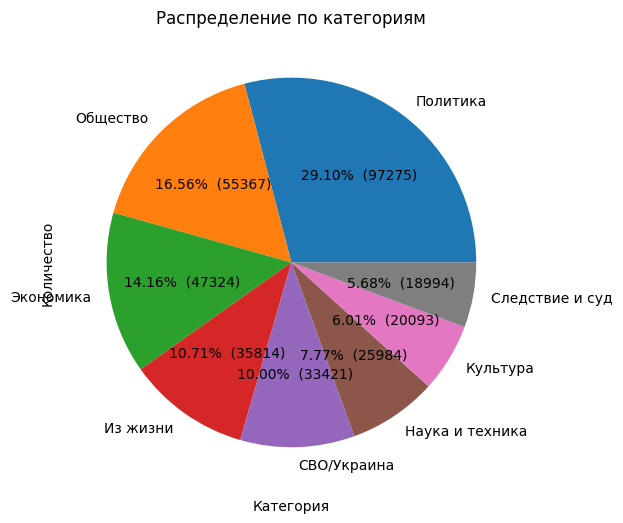

In [24]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
category_counts = actual_news_df['tags'].value_counts()

# Создание графика
plt.figure(figsize=(10, 6))
category_counts.plot(kind='pie', autopct=make_autopct(category_counts))
plt.title('Распределение по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

C:\Users\Doskin\AppData\Local\Temp\ipykernel_1896\1758919247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])


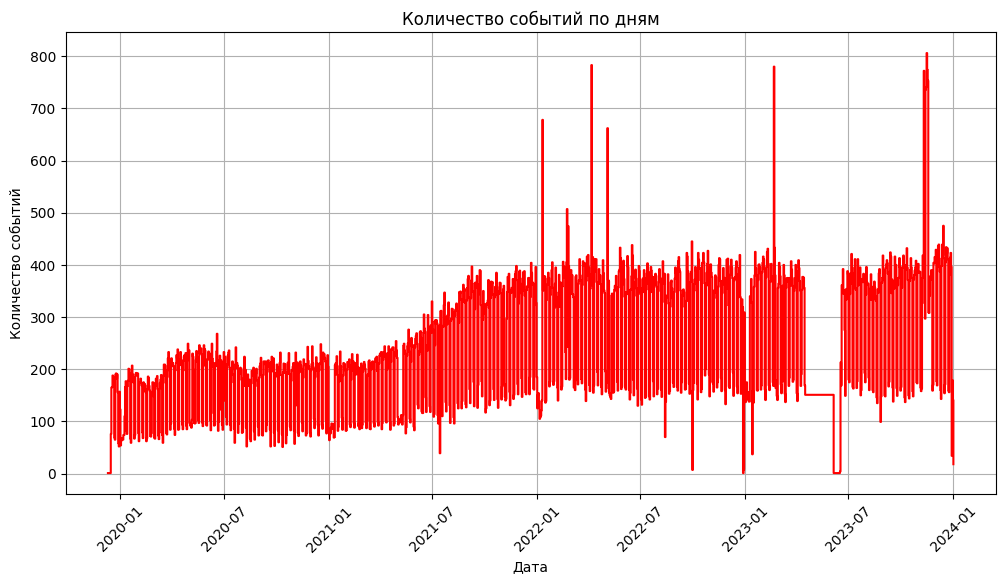

In [40]:
actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])

# Группировка данных по дате и подсчет количества событий в день
events_per_day = actual_news_df.groupby('date').size()

# Создание графика
plt.figure(figsize=(12, 6))
plt.plot(events_per_day.index, events_per_day.values, color='red',  drawstyle='steps-post')
plt.title('Количество событий по дням')

plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(np.arange(0, max(events_per_day.values), 100))
plt.show()

C:\Users\Doskin\AppData\Local\Temp\ipykernel_12992\10219950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])


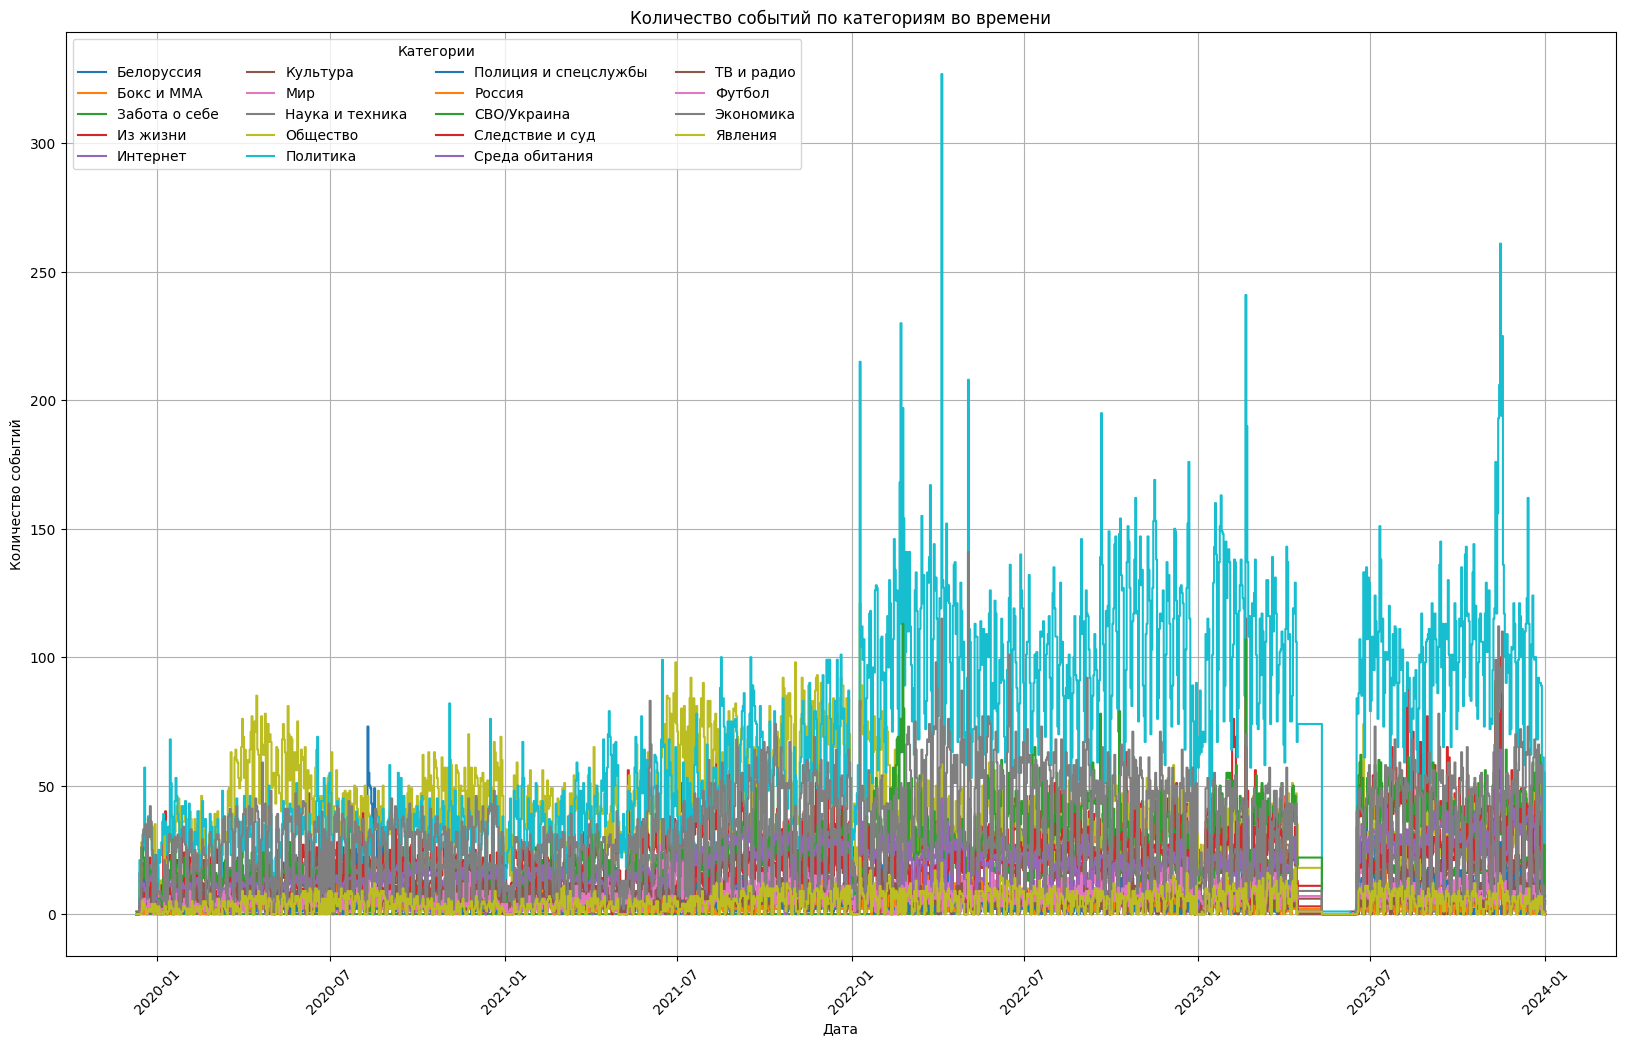

In [19]:
actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])

# Создание сводной таблицы с количеством событий по датам и категориям
pivot_table = actual_news_df.pivot_table(index='date', columns='tags', aggfunc='size', fill_value=0)
pivot_table
# Построение линейного графика
plt.figure(figsize=(20, 12))
for column in pivot_table.columns:
    col = (np.random.random (), np.random.random (), np.random.random ())
    plt.plot(pivot_table.index, pivot_table[column], label=column,  drawstyle='steps-mid')

plt.title('Количество событий по категориям во времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(loc='upper left', ncols=4, title="Категории")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [92]:
cut_df = news_df[['text', 'topic']].head(1500)
cut_df
logger.debug(f'Теги новостей: {cut_df["topic"].unique()}, Количество: {len(cut_df["topic"].unique())}')

2024-03-12 22:35:26.386 | DEBUG    | __main__:<module>:3 - Теги новостей: ['Библиотека' 'Россия' 'Мир' 'Экономика' 'Интернет и СМИ'], Количество: 5


## TF-IDF векторизация

In [ ]:
X_tfidf = tfidf_vectorizer(tokenize(cut_df['text']))

### K-means

In [ ]:
kmeans_clusterization(vectorized_text = X_tfidf,
                      n_clusters=4
                     )

### MiniBatchKMeans

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=X_tfidf,
    k=2,
    mb=500,
    print_silhouette_values=True,
)

### DBSCAN

In [ ]:
dbscan_clusterization(X=X_tfidf,
                      eps=1,
                      min_samples= 3  
                     )

In [ ]:
%%time
FastText_training(cut_df)

## Word2Vec векторизацияя

In [32]:
%%time
W2V_training(actual_news_df)

2024-03-15 01:08:07.185 | DEBUG    | __main__:W2V_training:2 - Токенизация....
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y0urc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\y0urc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
2024-03-15 09:14:01.545 | SUCCESS  | __main__:W2V_training:4 - Токенизация завершена успешно!
2024-03-15 09:14:01.556 | DEBUG    | __main__:W2V_training:9 - Обучение методом CBOW
2024-03-15 09:14:23.342 | DEBUG    | __main__:W2V_training:12 - Количество строк в корпусе: 334272
2024-03-15 09:14:23.343 | DEBUG    | __main__:W2V_training:13 - Обучение...
2024-03-15 09:25:05.606 | SUCCESS  | __main__:W2V_training:15 - Обучение завершено!
2024-03-15 09:25:07.720 | SUCCESS  | __main__:W2V_training:18 - Модель сохранена в w2v_cbow_334272.bin
2024-03-15 09:25:07.721 | DEBUG    | __main__:W2V_training:20 - Обучение 

CPU times: total: 9h 13min 54s
Wall time: 8h 29min 7s


### SkipGram

In [33]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
skipgram_vectorized_docs = W2V_vectorizer(actual_news_df, "w2v_skipgram_334272.bin")

2024-03-15 09:37:48,264 : INFO : Loading dictionaries from D:\VKR\researches\venv\Lib\site-packages\pymorphy3_dicts_ru\data
2024-03-15 09:37:49,797 : INFO : format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y0urc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\y0urc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2024-03-15 17:46:08,020 : INFO : loading projection weights from w2v_skipgram_334272.bin
2024-03-15 17:46:10,628 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (249154, 300) matrix of type float32 from w2v_skipgram_334272.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-03-15T17:46:10.628626', 'gensim': '4.3.2', 'python': '3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'loa

Метод векторизации Word2Vec
Количество векторов:  334272
Длина вектора:  334272


In [35]:
actual_news_df

,Unnamed: 0,url,title,text,topic,tags,date,tokens,vectors
0,0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15,"[россиянин_NOUN, дать_VERB, совет_NOUN, выбор_...","[0.19257335, 0.17542194, 0.62291235, -0.297329..."
1,1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15,"[спикер_NOUN, госдума_PROPN, вячеслав_PROPN, в...","[-0.17792627, -0.34801978, -0.6558388, -0.2631..."
2,2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Культура,2019-12-15,"[украинская_ADJ, лгбт_PROPN, активистка_NOUN, ...","[-0.1983621, 0.04533012, -0.07104129, -0.51291..."
3,4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15,"[исполнять_VERB, обязанность_NOUN, президент_N...","[-0.44590008, -0.7543499, -0.7748393, 0.022261..."
4,5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15,"[загс_NOUN, казань_PROPN, официально_ADV, всту...","[-0.06883645, 0.54412717, 0.06642661, -0.49711..."
...,...,...,...,...,...,...,...,...,...
423822,496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01,"[глава_NOUN, донецкий_ADJ, народный_ADJ, респу...","[1.2723573, -0.7883604, 1.3933644, 0.6185018, ..."
423823,496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01,"[январь_NOUN, 2024_ADJ, год_NOUN, начать_VERB,...","[-0.23262587, -0.0988141, -0.5287248, -0.99028..."
423824,496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01,"[январь_NOUN, 2024_ADJ, год_NOUN, материнский_...","[-0.5412548, 0.40643695, -0.3793554, -1.362960..."
423825,496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01,"[директор_NOUN, украинского_ADJ, институт_NOUN...","[-0.038669437, -1.5884598, -0.5304405, -0.8530..."


In [ ]:
dbscan_clusterization(X=skipgram_vectorized_docs,
                      eps=0.3,
                      min_samples=5
                      )

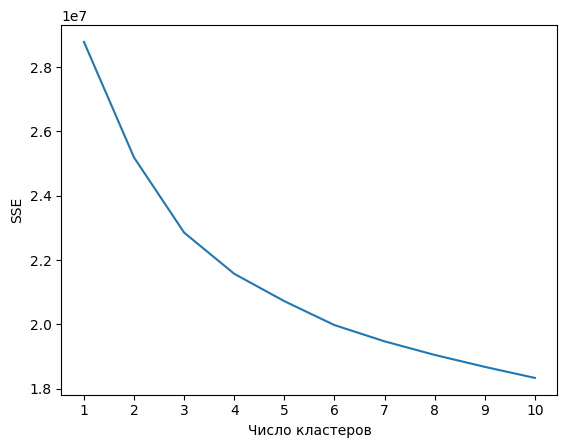

In [37]:
elbow_method(skipgram_vectorized_docs)

In [38]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=skipgram_vectorized_docs,
    k=4,
    mb=400,
    print_silhouette_values=True,
)

D:\VKR\researches\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4
Silhouette coefficient: 0.12
Inertia:21730495.95326343
Silhouette values:
    Cluster 0: Size:97178 | Avg:0.17 | Min:0.00 | Max: 0.34
    Cluster 2: Size:81847 | Avg:0.13 | Min:-0.03 | Max: 0.29
    Cluster 1: Size:103100 | Avg:0.09 | Min:-0.05 | Max: 0.24
    Cluster 3: Size:52147 | Avg:0.06 | Min:-0.08 | Max: 0.25


### CBOW

In [34]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
cbow_vectorized_docs = W2V_vectorizer(cut_df, "w2v_cbow_334272")

NameError: name 'cut_df' is not defined

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=cbow_vectorized_docs,
    k=4,
    mb=500,
    print_silhouette_values=True
)

In [ ]:
dbscan_clusterization(X=cbow_vectorized_docs,
                      eps=0.3,
                      min_samples=5
                      )